In [15]:
#KÜTÜPHANELERİN IMPORT EDİLMESİ
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import tensorflow as tf
import keras
from collections import Counter
import keras.backend as K
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import *

In [2]:
img_shape = 48 #görüntümüzün şekli(yükseklik ve genişlik değeri)
batch_size = 64 #veri gruplarının boyutu (aynı anda kaç adet veri işlenecek)
EPOCHS = 100  #eğitim adım sayısı
patience = 10 #early stop için
train_data_path = "../input/fer2013/train/" #eğitim verilerinin yolu
test_data_path = "../input/fer2013/test/"  #test verilerinin yolu

In [3]:
train_gen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,#veri kümesi üzerinden girişlerin ortalamasını sıfıra getirme
                                   featurewise_std_normalization=False,#girdiyi her özellik içindekini veri kümesinin standart sapmasına bölme
                                   rotation_range=10,#görüntüyü döndürme
                                   width_shift_range=0.1,#görüntüyü (yatay) şekilde kaydırma
                                   height_shift_range=0.1,#görüntüyü (dikey) şekilde kaydırma
                                   zoom_range=0.1,#görüntüyü yakınlaştırma
                                   horizontal_flip=True
                              )

test_gen  = ImageDataGenerator(rescale = 1./255)#görüntüleri yeniden ölçeklendirme/hesaplamadan önce 

In [4]:
train_data = train_gen.flow_from_directory(
    train_data_path,#pathimizi veriyoruz
    class_mode="categorical",#döndürülen etiket dizilerinin türünü belirleme
    target_size=(img_shape,img_shape),#yükseklik ve genişlik değerlerinin verilmesi (daha sonra boyutlandırma yapılacak)
    batch_size=batch_size
    
)

test_data = test_gen.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    shuffle=True,#verilerin karıştırılıp karıştırılamayacağına karar verir false ise sıralama yapar
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# VGG16
vgg_model = tf.keras.applications.VGG16(input_shape=(img_shape,img_shape,3),include_top=False)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [7]:
#Katmanları dondurma - freez   --tam bağlantı katmanını değiştirme onun dışındaki önceki katmanları freezleme

for layer in vgg_model.layers[:11]:
    layer.trainable=False

In [8]:
#Transfer Learning 

model=Sequential()
model.add(vgg_model)#modelin eklenmesi                 #regularizer=düzenleyici 
model.add(BatchNormalization()) #normalleştirme katmanı
model.add(GaussianNoise(0.01))#overfitting azaltmak için kullanışlı 
model.add(GlobalAveragePooling2D())#global ortaklama işlemi
#kernel_regularizer=katmanın çekirdeğine ceza       bias_regularizer=katmanın önyargısına ceza 
model.add(Flatten())  #model.add(Flatten(input_shape=(7,7,512)))  //   #dense içinde input_dim = (7*7*512)
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()#modelin özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 512)         2048      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [9]:
#metriklerin hesaplanması
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#öğrenme oranını belirleme

model.compile(optimizer=adam, loss="categorical_crossentropy",metrics=METRICS)#modelin derlenmesi

In [10]:
counter = Counter(train_data.classes)#Counter sayılar dictionary(sözlük) olarak saklanır                         
max_val = float(max(counter.values()))#floata çevirme       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()} 
#dengesiz verilere(sınıf dengesizliğine) çözüm bulmak için kullanılır 
#yetersiz temsil edilen sınıflara daha fazla dikkat edilir,sınıf ağırlıkları kullanılır

lrd = ReduceLROnPlateau(monitor = "val_loss",patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
#metrik gelişmeyi durdurduğunda öğrenme oranını azaltma
checkpoint = ModelCheckpoint("/kaggle/working/kaydedilen_model.h5")#modelin kaydedilmesi
earlystop = EarlyStopping(verbose=1, patience=20)#tekrarı önlemek
#modelin eğitilmesi
history=model.fit(train_data,
                  validation_data=test_data,#her eğitim sonunda model metriğinin değerlendirildiği veriler
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,checkpoint,earlystop],#eğitim sırasında uygulanacakların listesi
                  class_weight = class_weights)#sınıf ağırlıkları

2022-12-20 18:09:07.252629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-20 18:09:14.516941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


449/449 [==============================] - 351s 742ms/step - loss: 6.1104 - accuracy: 0.8109 - precision: 0.1724 - recall: 0.0852 - auc: 0.5274 - f1_score: 0.1135 - val_loss: 6.2928 - val_accuracy: 0.7685 - val_precision: 0.1826 - val_recall: 0.1785 - val_auc: 0.5141 - val_f1_score: 0.1798
Epoch 2/100
449/449 [==============================] - 100s 222ms/step - loss: 5.4400 - accuracy: 0.8285 - precision: 0.2289 - recall: 0.0845 - auc: 0.5631 - f1_score: 0.1230 - val_loss: 3.9359 - val_accuracy: 0.7893 - val_precision: 0.1990 - val_recall: 0.1570 - val_auc: 0.5881 - val_f1_score: 0.1749
Epoch 3/100
449/449 [==============================] - 98s 218ms/step - loss: 5.0155 - accuracy: 0.8374 - precision: 0.2668 - recall: 0.0789 - auc: 0.5845 - f1_score: 0.1213 - val_loss: 2.7288 - val_accuracy: 0.8601 - val_precision: 0.6721 - val_recall: 0.0403 - val_auc: 0.7068 - val_f1_score: 0.0745
Epoch 4/100
449/449 [==============================] - 97s 216ms/step - loss: 4.7324 - accuracy: 0.8422 

In [11]:
#Modelin değerlendirilmesi /evaluate
train_evaluate = model.evaluate(train_data)
test_evaluate = model.evaluate(test_data)

113/113 [==============================] - 13s 118ms/step - loss: 1.3886 - accuracy: 0.9034 - precision: 0.6738 - recall: 0.6271 - auc: 0.9037 - f1_score: 0.6497


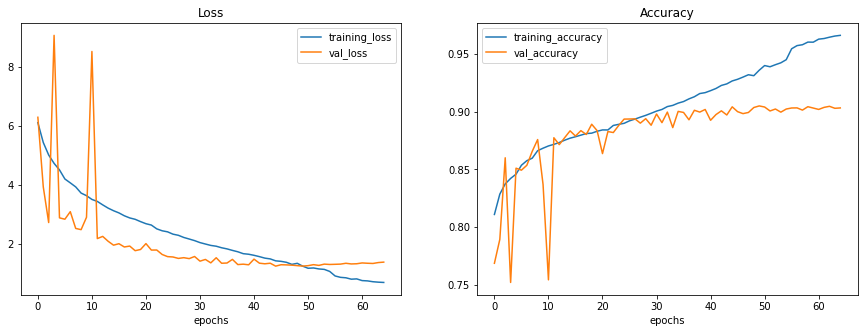

In [12]:
#accuracy ve loss değerlerini çizdirme
def model_cizdir(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

   

    plt.figure(figsize=(15,5))

    #loss değerlerini çizdirme
    plt.subplot(1, 2, 1)
    plt.plot(loss, label = "training_loss")
    plt.plot(val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #accuracy değerlerini çizdirme
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label = "training_accuracy")
    plt.plot(val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

model_cizdir(history)

In [18]:
y_true = test_data.classes
y_pred =  model.predict(test_data)
y_pred= tf.argmax(y_pred, axis = 1).numpy()
siniflar = ["Kızgın","İğrenme","Korku","Mutlu","Doğal","Üzgün","Şaşkın"]

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

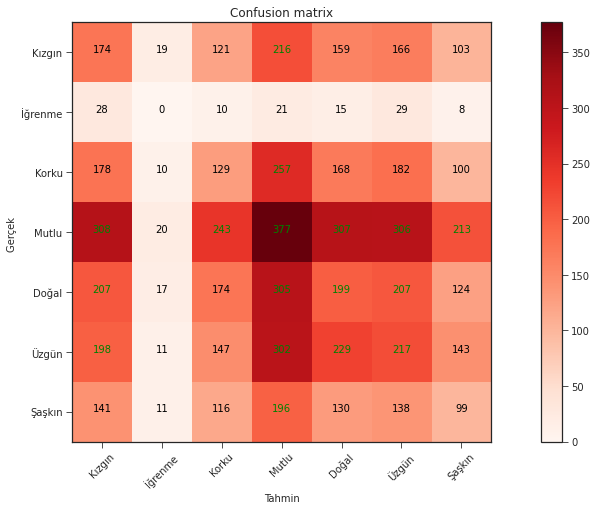

In [52]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-ticks')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(siniflar))
plt.xticks(tick_marks, siniflar, rotation=45)
plt.yticks(tick_marks, siniflar)    

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="green" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Gerçek ')
plt.xlabel('Tahmin')
plt.show()

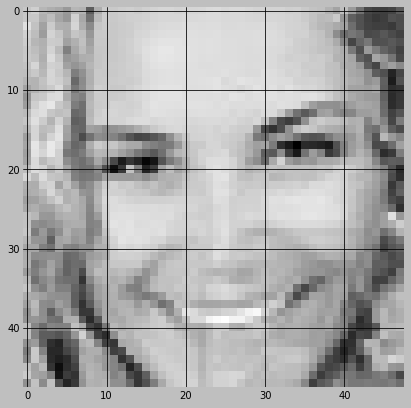

In [25]:
plt.style.use("grayscale")
img_path="/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg"
test_image=image.load_img(img_path,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [26]:
img=image.load_img(img_path,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)


result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[3])

[0. 0. 0. 1. 0. 0. 0.]
Tahmin edilen sınıf: Mutlu
Gerçek sınıfı: Mutlu


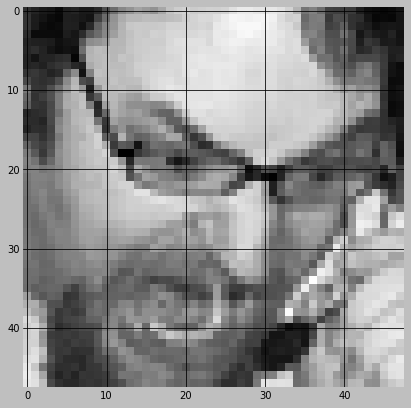

In [27]:
img_path2="/kaggle/input/fer2013/test/angry/PrivateTest_10131363.jpg"
test_image=image.load_img(img_path2,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [28]:
img=image.load_img(img_path2,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[0])

[1.0000000e+00 0.0000000e+00 2.6015128e-37 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
Tahmin edilen sınıf: Kızgın
Gerçek sınıfı: Kızgın


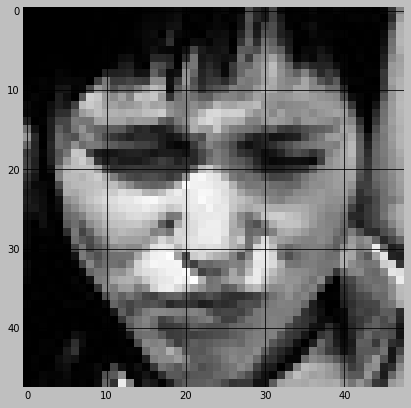

In [29]:
img_path4="/kaggle/input/fer2013/test/sad/PrivateTest_10455506.jpg"
test_image=image.load_img(img_path4,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [30]:
img=image.load_img(img_path4,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[5])

[0. 0. 0. 0. 0. 1. 0.]
Tahmin edilen sınıf: Üzgün
Gerçek sınıfı: Üzgün


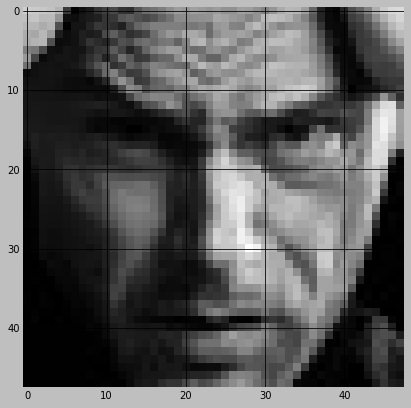

In [44]:
img_path5="/kaggle/input/fer2013/test/fear/PrivateTest_10254684.jpg"
test_image=image.load_img(img_path5,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [46]:
img=image.load_img(img_path5,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[2])

[3.6613428e-20 2.3090628e-22 3.7413472e-24 3.4093191e-38 4.9228636e-24
 1.0000000e+00 0.0000000e+00]
Tahmin edilen sınıf: Üzgün
Gerçek sınıfı: Korku


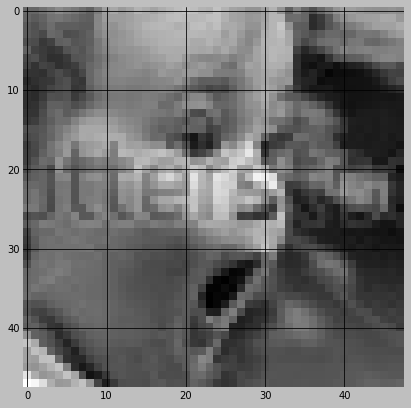

In [33]:
img_path6="/kaggle/input/fer2013/test/surprise/PrivateTest_1076980.jpg"
test_image=image.load_img(img_path6,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [34]:
img=image.load_img(img_path6,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[6])

[0.0000000e+00 0.0000000e+00 9.1544145e-17 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00]
Tahmin edilen sınıf: Şaşkın
Gerçek sınıfı: Şaşkın


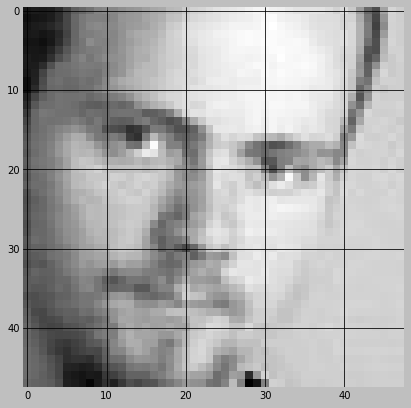

In [47]:
img_path7="/kaggle/input/fer2013/test/neutral/PrivateTest_10086748.jpg"
test_image=image.load_img(img_path7,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [48]:
img=image.load_img(img_path7,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[4])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2269724e-19 1.0000000e+00
 0.0000000e+00 4.6247901e-34]
Tahmin edilen sınıf: Doğal
Gerçek sınıfı: Doğal


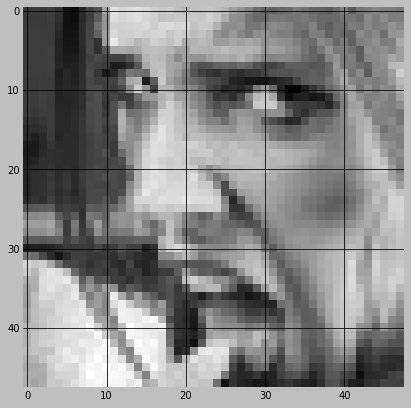

In [49]:
img_path8="/kaggle/input/fer2013/test/disgust/PrivateTest_21629266.jpg"
test_image=image.load_img(img_path8,target_size= (img_shape,img_shape),color_mode="grayscale")
test_image=image.img_to_array(test_image)
plt.imshow(test_image)
plt.show()

In [50]:
img=image.load_img(img_path8,target_size=(img_shape,img_shape))
img = np.expand_dims(img, axis=0)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print("Tahmin edilen sınıf:" ,siniflar[y_pred])
print("Gerçek sınıfı:" ,siniflar[1])

[1.0000000e+00 2.8505213e-35 2.0772483e-24 0.0000000e+00 0.0000000e+00
 1.9853244e-32 0.0000000e+00]
Tahmin edilen sınıf: Kızgın
Gerçek sınıfı: İğrenme
